<a href="https://colab.research.google.com/github/giozu/FEniCS/blob/main/2D%20problems/2d_poisson_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Equation and problem definition
Given a domain $\Omega \subset \mathbb{R}^n$ with boundary $\partial
\Omega = \Gamma_{D}$, the Poisson's equation with
particular boundary conditions is:

$$
\begin{align}
- \nabla^{2} u &= f \quad {\rm in} \ \Omega, \\
u_D &= 0 \quad {\rm on} \ \Gamma_D, \\
\end{align}
$$

The variational problem requires to find $u \in V$ such that

$$
a(u, v) = L(v) \quad \forall \ v \in V,
$$

where $V$ is a suitable function space and

$$
\begin{align}
a(u, v) &:= \int_{\Omega} \nabla u \cdot \nabla v \, {\rm d} x, \\
L(v)    &:= \int_{\Omega} f v \, {\rm d} x
\end{align}
$$

The expression $a(u, v)$ is a bilinear form and $L(v)$ is a linear functional. It is assumed that all functions in $V$ satisfy the boundary conditions.

### Problem parameters
In this case, we pose:
* $u_D(x,y) = 1+x^2+y^2$
* $f = 6$

## Initializing notebook plotting
When running a python notebook, a special line is necessary to show the plots.

In [10]:
%matplotlib inline

## Implementation
The modules that will be used are imported:

In [11]:
import numpy as np

import ufl
from ufl import ds, dx, grad, inner

from dolfinx import fem, io, mesh, plot
from dolfinx.io import gmshio # to import gmsh functions
from dolfinx import geometry # to define the line plot

from mpi4py import MPI

# from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

import matplotlib.pyplot as plt

### Mesh generation and functional spaces
We create the mesh using dedicated functions (e.g., {py:func} `create_rectangle<dolfinx.mesh.create_rectangle>`), or we import it from a .msh file (made with gmsh). Then, we define a finite element space $V$ on the mesh. In this case `V` is the space of continuous Lagrange finite elements of degree 1.

To apply Dirichlet boundary conditions, we find the mesh facets (entities of topological co-dimension 1) that lie on the boundary $\Gamma_D = \partial \Omega$ using `locate_entities_boundary`. The function is provided with a boolean function that returns `True` for points `x` on the boundary and `False` otherwise.

Lastly, we find the degrees-of-freedom that are associated with the boundary facets using `locate_dofs_topological`, and use `dirichletbc` to create a `DirichletBCMetaClass` class that represents the boundary condition.

### Class definition

In [12]:
class poisson_problem():
    def __init__(self):
        
        # Domain
        self.domain, __, __ = gmshio.read_from_msh("esagonino.msh", MPI.COMM_WORLD, gdim = 2)
        # self.domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)
        self.tdim = self.domain.topology.dim
        self.fdim = self.tdim - 1
        self.domain.topology.create_connectivity(self.fdim, self.tdim)

        # Functional spaces
        self.P1 = ufl.FiniteElement("Lagrange", self.domain.ufl_cell(), 1) # standard P1 linear Lagrange element
        self.V = fem.FunctionSpace(self.domain, self.P1)
        # self.V = fem.FunctionSpace(self.domain, ("CG", 1))
        self.W = fem.FunctionSpace(self.domain, ufl.VectorElement("Lagrange", self.domain.ufl_cell(), 1))

        # Test and trial functions
        self.u = ufl.TestFunction(self.V)
        self.v = ufl.TrialFunction(self.V)
        self.x = ufl.SpatialCoordinate(self.domain)

    def parameters(self, f):
        self.forcingValue = f
        print('forcing = {:.0f}'.format(f))
        self.forcing = fem.Constant(self.domain, ScalarType(self.forcingValue))

    def boundaryConditions(self):
        uD = fem.Function(self.V)
        uD.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2) # 1 + x^2 + 2y^2
        self.facets = mesh.exterior_facet_indices(self.domain.topology)
        self.dofs = fem.locate_dofs_topological(V=self.V, entity_dim=self.fdim, entities=self.facets)
        # self.bc = fem.dirichletbc(value=uD, dofs=self.dofs, V=self.V)
        self.bc = fem.dirichletbc(value = uD, dofs = self.dofs)

    def assemble(self):
        # Variational forms
        self.lhs = inner(grad(self.u), grad(self.v)) * dx
        self.rhs = inner(self.forcingValue, self.v) * dx
        # self.lhs = ufl.dot(ufl.grad(self.u), ufl.grad(self.v)) * ufl.dx
        # self.rhs = self.forcingValue * self.v * ufl.dx

    def solve(self):
        self.problem = fem.petsc.LinearProblem(self.lhs, self.rhs, bcs=[self.bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
        self.solution = self.problem.solve()
        return self.solution
    
    def gradient(self):
        # grad_u_expr = fem.Expression(grad(uh)[0], V.element.interpolation_points()) # d/dx
        grad_u_expr = fem.Expression(grad(self.solution), self.W.element.interpolation_points())
        grad_u = fem.Function(self.W)
        grad_u.interpolate(grad_u_expr)
        return grad_u
    
    def linePlot(self, xi, xf, yi, yf, N):
        points = np.zeros((3, N))

        points[0] = np.linspace(xi, xf, N)
        points[1] = np.linspace(yi, yf, N)

        u_values = []
        cells = []
        points_on_proc = []

        bb_tree = geometry.BoundingBoxTree(self.domain, self.tdim)

        cell_candidates = geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = geometry.compute_colliding_cells(self.domain, cell_candidates, points.T)

        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
                
        points_on_proc = np.array(points_on_proc, dtype=np.float64)
        u_values = self.solution.eval(points_on_proc, cells)
        
        return points_on_proc, u_values

Problem solution

In [13]:
poisson = poisson_problem()

S = 3 # production rate (1e-7)
D = 0.3 # diffusivity
forcing = - 6

poisson.parameters(forcing)
poisson.boundaryConditions()
poisson.assemble()
uh = poisson.solve()

Info    : Reading 'esagonino.msh'...
Info    : 13 entities
Info    : 817 nodes
Info    : 1536 elements
Info    : Done reading 'esagonino.msh'
forcing = -6


## Visualization
displayed using [pyvista](https://docs.pyvista.org/).



No module named 'trame'

Falling back to a static output.
  warnings.warn(



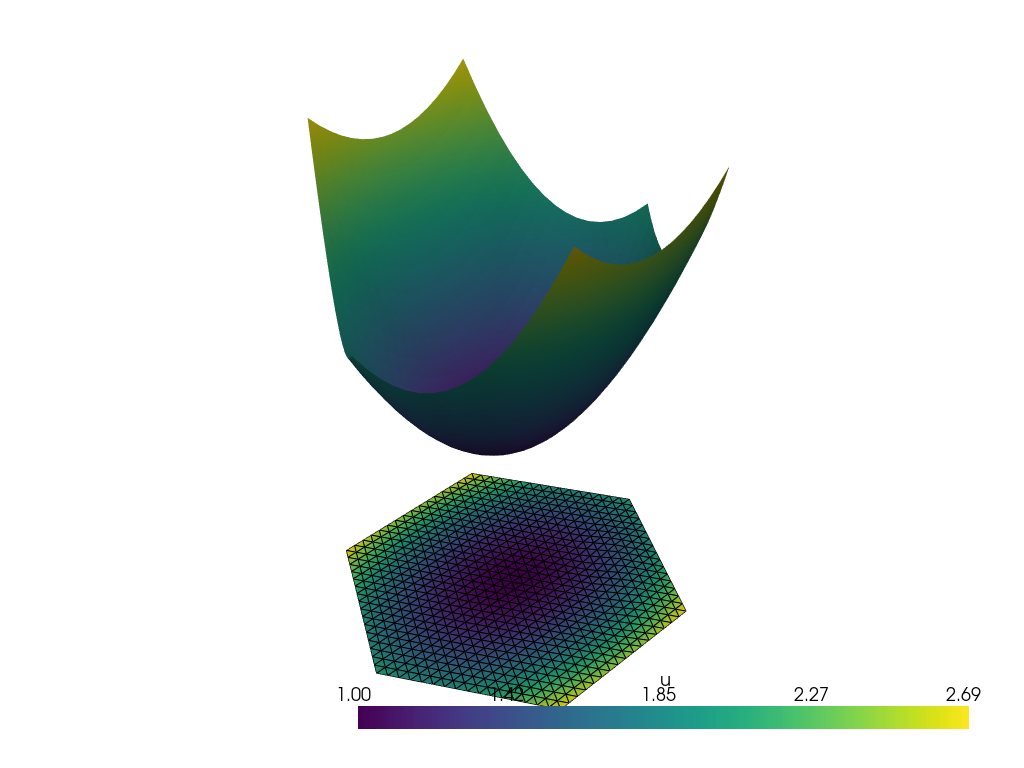

In [14]:
try:
    import pyvista
    cells, types, x = plot.create_vtk_mesh(poisson.V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()

except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")


## Curve plots throughout the mesh
It is possible to plot the finite element solution $u_h$ along a determined line $y=f(x)$. First, we define the set of points belonging to the line, then we evaluate $u_h$ at these points.

Since the finite element solution is a linear combination of all degrees of freedom, $u_h = \sum_{i=1}^N c_i \phi_i(x)$, where $c_i$ is the coefficient of $u_i$ and $\phi_i$ is the basis function, we can compute the solution at any point in $\Omega$. However, as a mesh consists of a large set of degrees of freedom (i.e. $N$ is large), we want to reduce the number of evaluations of the basis functions. This is efficiently done by creating a bounding box tree of the cells of the mesh, allowing a quick recursive search through the mesh entities.

In [15]:
N = 101
points, u_lineplot = poisson.linePlot(0.85, 0.85, 0.0, 1.5, N)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



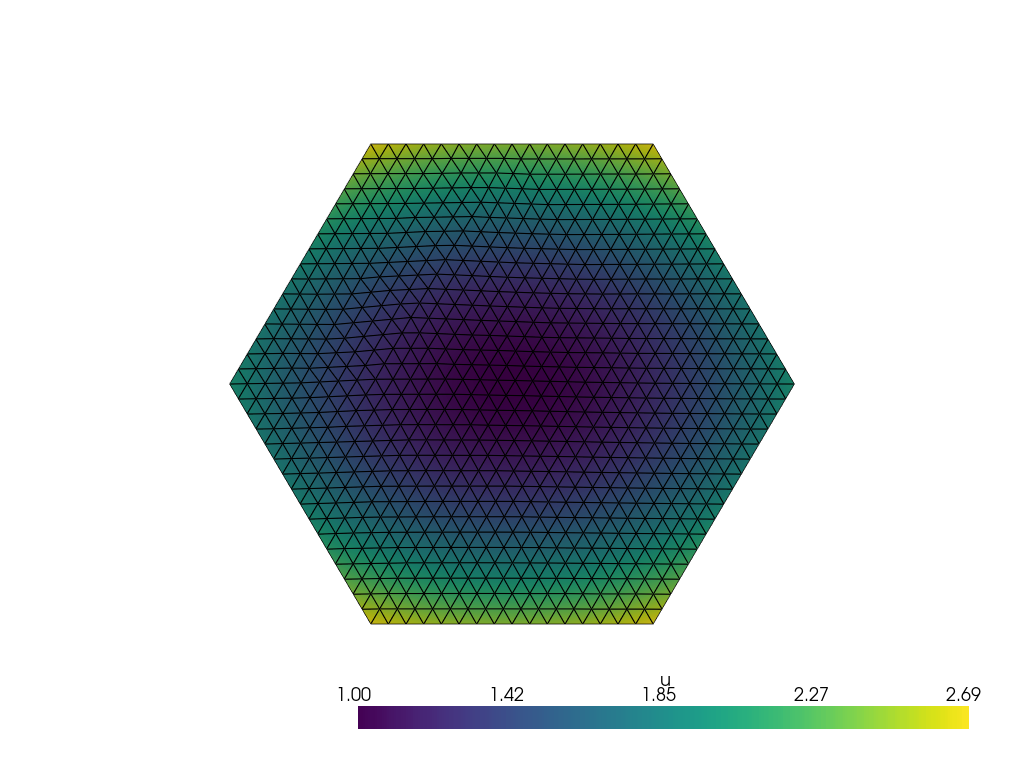

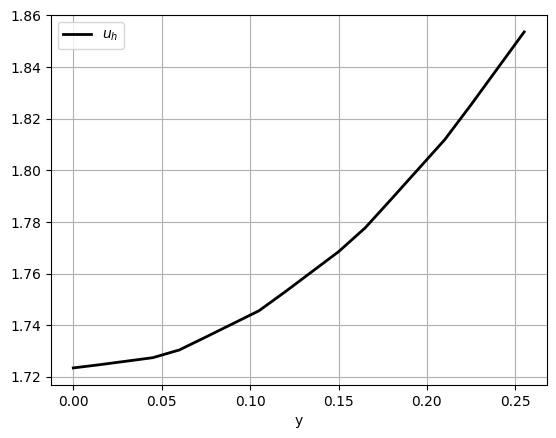

In [16]:
# 2D plot
u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(poisson.V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

# Line plot
fig = plt.figure()
plt.plot(points[:,1], u_lineplot, "k", linewidth=2, label="$u_h$")
plt.grid(True)
plt.xlabel("y")
plt.legend()

## Evaluate the gradient of the solution
We evaluate the gradient of $u_h$. Then we plot $\frac{\partial u_h}{\partial x}$. Also, we export the paraview files (.h5 and .xdmf).


No module named 'trame'

Falling back to a static output.
  warnings.warn(



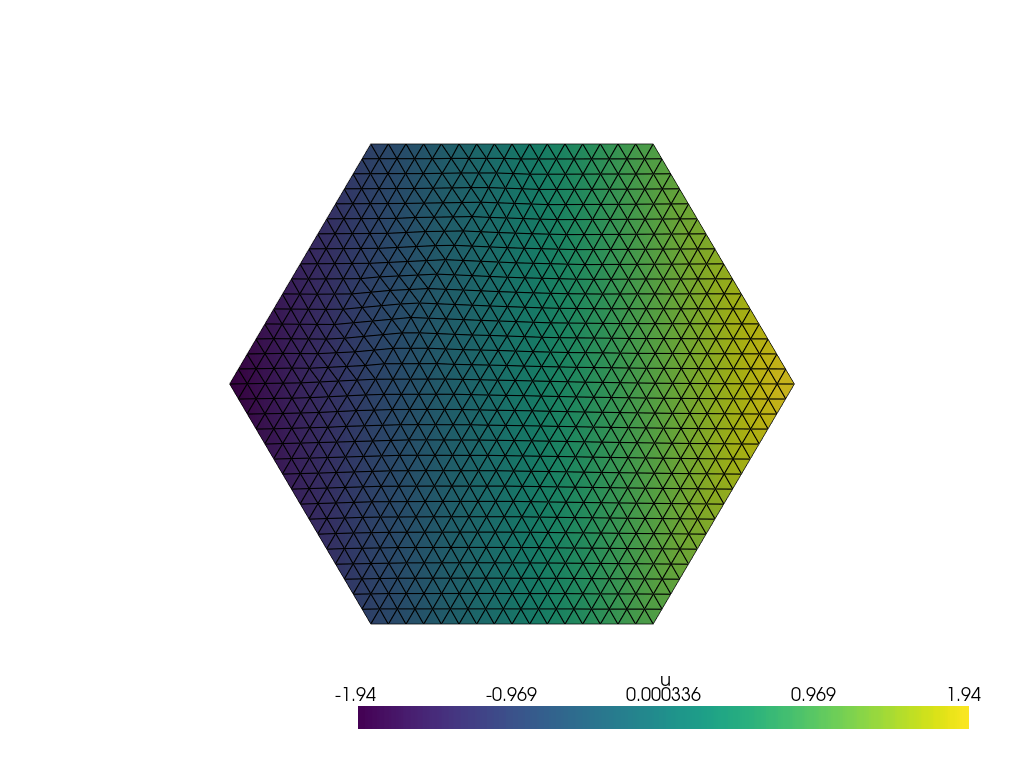

In [17]:
# 2D plot
u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(poisson.V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = poisson.gradient().sub(0).collapse().x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

# The solution can be written to a file, and visualize it with ParaView or VisIt:
with io.XDMFFile(poisson.domain.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(poisson.domain)
    file.write_function(poisson.gradient())


The Poisson's equation can be derived from the steady-state **continuity equation**:
$$
\frac{\partial u}{\partial t} + \nabla \cdot j = S
$$
with $j = - D \nabla u$ being the total flux and $S$ the volumetric source for $u$.

Below, the total flux is evaluated.

In [18]:
flux = fem.Function(poisson.V) # new dolfinx function
flux = poisson.gradient()
flux.x.array[:] *= - D # rescale

# The solution can be written to a file, and visualize it with ParaView or VisIt:
with io.XDMFFile(poisson.domain.comm, "out_poisson/poisson_flux.xdmf", "w") as file:
    file.write_mesh(poisson.domain)
    file.write_function(flux)